# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [5]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [6]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [7]:
# Test FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)

Gradient check passed!


In [8]:
# TODO: Test storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [9]:
# Test model.py compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# Test backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W0
Gradient check passed!
Checking gradient for B0
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [10]:
# Test l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W0
Gradient check passed!
Checking gradient for B0
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [13]:
# Finally, implement predict function!
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [16]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD())

loss_history, train_history, val_history = trainer.fit()

Loss: 2.242923, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.142792, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.167898, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.214401, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306899, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331796, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315803, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.040757, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.153691, Train accuracy: 0.212889, val accuracy: 0.221000
Loss: 2.017334, Train accuracy: 0.239889, val accuracy: 0.245000
Loss: 2.035127, Train accuracy: 0.256889, val accuracy: 0.253000
Loss: 1.929650, Train accuracy: 0.269111, val accuracy: 0.269000
Loss: 1.991373, Train accuracy: 0.279333, val accuracy: 0.283000
Loss: 1.802370, Train accuracy: 0.307111, val accuracy: 0.313000
Loss: 1.889998, Train accuracy: 0.335111, val accuracy: 0.336000
Loss: 2.080546, Train acc

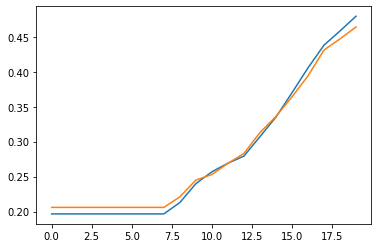

In [17]:
plt.plot(train_history)
plt.plot(val_history)

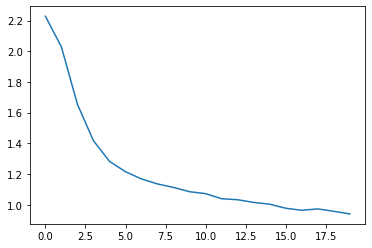

In [26]:
plt.plot(loss_history)


# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [19]:
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5 * initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.309754, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.217571, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.236721, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310234, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285209, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233009, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259510, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.156655, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.172241, Train accuracy: 0.203778, val accuracy: 0.211000
Loss: 2.270294, Train accuracy: 0.228333, val accuracy: 0.232000
Loss: 2.172984, Train accuracy: 0.249222, val accuracy: 0.252000
Loss: 1.919335, Train accuracy: 0.264667, val accuracy: 0.262000
Loss: 2.065160, Train accuracy: 0.273556, val accuracy: 0.271000
Loss: 2.124442, Train accuracy: 0.283444, val accuracy: 0.289000
Loss: 1.914513, Train accuracy: 0.301333, val accuracy: 0.302000
Loss: 1.916397, Train acc

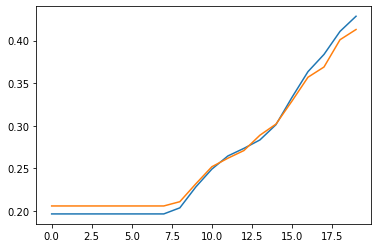

In [20]:
plt.plot(train_history)
plt.plot(val_history)

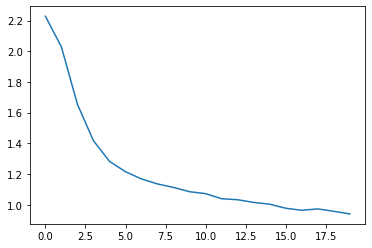

In [25]:
plt.plot(loss_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [22]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate_decay=0.99)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.101188, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.783380, Train accuracy: 0.398444, val accuracy: 0.399000
Loss: 1.734169, Train accuracy: 0.520889, val accuracy: 0.510000
Loss: 1.794008, Train accuracy: 0.602111, val accuracy: 0.593000
Loss: 1.642824, Train accuracy: 0.659333, val accuracy: 0.650000
Loss: 1.165376, Train accuracy: 0.704444, val accuracy: 0.685000
Loss: 1.285093, Train accuracy: 0.701000, val accuracy: 0.677000
Loss: 0.995928, Train accuracy: 0.719778, val accuracy: 0.688000
Loss: 1.475782, Train accuracy: 0.734333, val accuracy: 0.682000
Loss: 1.218336, Train accuracy: 0.755333, val accuracy: 0.715000
Loss: 1.100189, Train accuracy: 0.738111, val accuracy: 0.689000
Loss: 0.851399, Train accuracy: 0.776444, val accuracy: 0.724000
Loss: 0.992082, Train accuracy: 0.786000, val accuracy: 0.721000
Loss: 0.849638, Train accuracy: 0.792778, val accuracy: 0.733000
Loss: 1.151881, Train accuracy: 0.794333, val accuracy: 0.726000
Loss: 0.986567, Train acc

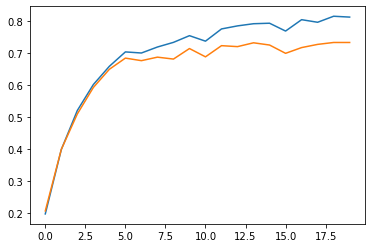

In [23]:
plt.plot(train_history)
plt.plot(val_history)

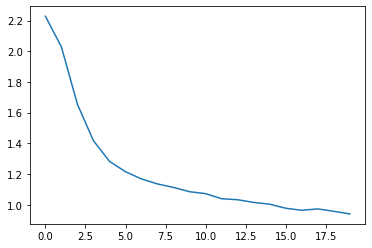

In [24]:
plt.plot(loss_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [32]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.335368, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.327880, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333188, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294355, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.293752, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.230480, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.289412, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.239533, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.297490, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.328231, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.221167, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.775620, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.178323, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.538814, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.940456, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.454609, Train acc

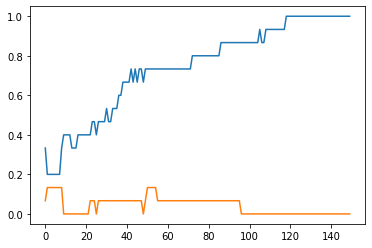

In [28]:
plt.plot(train_history)
plt.plot(val_history)

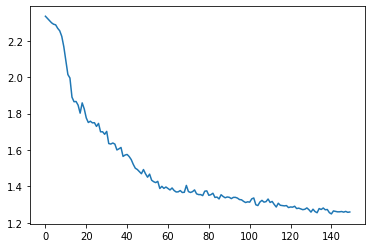

In [29]:
plt.plot(loss_history)


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [35]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.319666, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.216709, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.133201, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.486757, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.537559, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 0.540969, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.605009, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 0.876027, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.459151, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.017431, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.353569, Train accuracy: 0.600000, val accuracy: 0.133333
Loss: 0.727375, Train accuracy: 0.533333, val accuracy: 0.133333
Loss: 0.420283, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.500110, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.153831, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.351417, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [47]:
dataset = Dataset(train_X, train_y, val_X, val_y)

# Let's train the best one-hidden-layer network we can

hidden_layer_size = 10
learning_rate_decay = 0.99
batch_size = 16
num_epochs = 50

reg_strengths = [1e-2, 1e-3, 1e-4]
learning_rates = [1e-2, 5e-3, 1e-3]

best_val_accuracy = None
best_classifier = None

for reg_strength in reg_strengths:
    for learning_rate in learning_rates:
        model = TwoLayerNet(n_input=train_X.shape[1], n_output=10,
                            hidden_layer_size=hidden_layer_size, reg=reg_strength)
        trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate,
                          learning_rate_decay=learning_rate_decay,
                          num_epochs=num_epochs, batch_size=batch_size)
        loss_history, train_history, val_history = trainer.fit(out=False)
        accuracy = val_history[-1]
        if best_val_accuracy is None or best_val_accuracy < accuracy:
            best_classifier = model
            best_val_accuracy = accuracy
            best_reg_strength = reg_strength
            best_learning_rate = learning_rate
        print('reg_strength =', reg_strength, flush=True)
        print('learning_rate =', learning_rate, flush=True)
        print('accuracy =', accuracy, flush=True)

print('Best reg_strength =', best_reg_strength, flush=True)
print('Best learning_rate =', best_learning_rate, flush=True)
print('Best accuracy =', best_val_accuracy, flush=True)

print('best validation accuracy achieved: %f' % best_val_accuracy)

100%|██████████| 50/50 [00:48<00:00,  1.03it/s]

reg_strength = 0.01
learning_rate = 0.01
accuracy = 0.547



100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

reg_strength = 0.01
learning_rate = 0.005
accuracy = 0.587



100%|██████████| 50/50 [01:00<00:00,  1.21s/it]

reg_strength = 0.01
learning_rate = 0.001
accuracy = 0.46



100%|██████████| 50/50 [01:03<00:00,  1.27s/it]

reg_strength = 0.001
learning_rate = 0.01
accuracy = 0.617



100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

reg_strength = 0.001
learning_rate = 0.005
accuracy = 0.61



100%|██████████| 50/50 [00:43<00:00,  1.15it/s]

reg_strength = 0.001
learning_rate = 0.001
accuracy = 0.569



100%|██████████| 50/50 [00:43<00:00,  1.15it/s]

reg_strength = 0.0001
learning_rate = 0.01
accuracy = 0.627



100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

reg_strength = 0.0001
learning_rate = 0.005
accuracy = 0.588



100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

reg_strength = 0.0001
learning_rate = 0.001
accuracy = 0.562
Best reg_strength = 0.0001
Best learning_rate = 0.01
Best accuracy = 0.627
best validation accuracy achieved: 0.627000


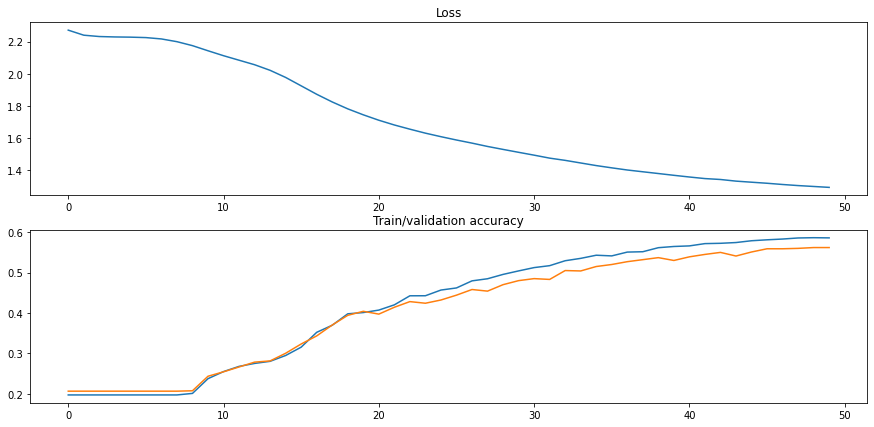

In [48]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [49]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.573000
